In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image

In [2]:
# Define the path to the dataset
data_dir = "affectnet"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

In [3]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((48, 48)),  # Resize images to a fixed size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])


In [4]:
# Custom Dataset class to load images and labels
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.dataset = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, label

In [5]:
# Create train and test datasets
train_dataset = CustomDataset(train_dir, transform=transform)
test_dataset = CustomDataset(test_dir, transform=transform)

In [6]:
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Define the emotion categories
emotion_categories = {
    1: "Neutral",
    2: "Happiness",
    3: "Sadness",
    4: "Surprise",
    5: "Afraid",
    6: "Disgusted",
    7: "Angry",
    8: "Contempt"
}

In [8]:
# Define the CNN model
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(EmotionCNN, self).__init__()
        self.resnet = resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [9]:
# Initialize the model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN(num_classes=8).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

c:\users\03aay\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\users\03aay\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(train_loader)}")


Epoch [1/20] Loss: 2.010980660374831
Epoch [2/20] Loss: 1.7693768812094623
Epoch [3/20] Loss: 1.6549200384240401
Epoch [4/20] Loss: 1.5733615623311958
Epoch [5/20] Loss: 1.5021443504553575
Epoch [6/20] Loss: 1.3990638963124047
Epoch [7/20] Loss: 1.3350179343812378
Epoch [8/20] Loss: 1.2165209232312948
Epoch [9/20] Loss: 1.1062003581630073
Epoch [10/20] Loss: 0.9316257473669554
Epoch [11/20] Loss: 0.7697306886496331
Epoch [12/20] Loss: 0.5988064916269017
Epoch [13/20] Loss: 0.4701636733434461
Epoch [14/20] Loss: 0.3701313557442625
Epoch [15/20] Loss: 0.28390814532876496
Epoch [16/20] Loss: 0.25640876731469564
Epoch [17/20] Loss: 0.24308762264245676
Epoch [18/20] Loss: 0.21482104572810626
Epoch [19/20] Loss: 0.18422596425813462
Epoch [20/20] Loss: 0.19428593689869894


In [11]:
# Evaluation on the test set
model.eval()
correct = 0
total = 0
all_predicted = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

Accuracy on test set: 42.25%


In [12]:
# Create a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predicted)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[202  13  71  34  44  18  53  65]
 [ 23 268  26  32  16  26  20  89]
 [ 81  23 201  20  47  32  69  27]
 [ 73  32  31 171 118  23  26  26]
 [ 42  19  45  66 254  27  37  10]
 [ 69  16  50  24  28 200  81  32]
 [ 97   7  60  15  35  62 200  24]
 [ 94  53  44  20   9  33  53 194]]


<AxesSubplot: >

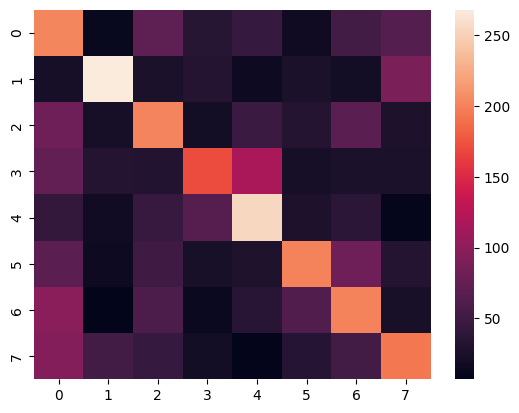

In [13]:
sns.heatmap(conf_matrix)

In [14]:
# Save the model to an h5 file
torch.save(model.state_dict(), "emotion_recognition_model.h5")

In [15]:
# Function to decode emotion labels
def decode_emotion_label(label):
    return emotion_categories[label]

# Example usage of decoding labels
example_label = 1
print(f"Emotion Category for label {example_label}: {decode_emotion_label(example_label)}")

Emotion Category for label 1: Neutral


In [16]:
# Function to create a radar chart for emotion categories and probabilities
def radar_chart_for_image(model, image):
    model.eval()
    image = image.to(device)
    with torch.no_grad():
        output = model(image.unsqueeze(0))
        probabilities = torch.softmax(output, dim=1).squeeze().cpu().numpy()

    angles = np.linspace(0, 2 * np.pi, len(emotion_categories), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))
    probabilities = np.concatenate((probabilities, [probabilities[0]]))

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, probabilities, 'o-', linewidth=2)
    ax.fill(angles, probabilities, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(list(emotion_categories.values()))
    ax.set_title("Emotion Probabilities", fontsize=14)
    ax.grid(True)

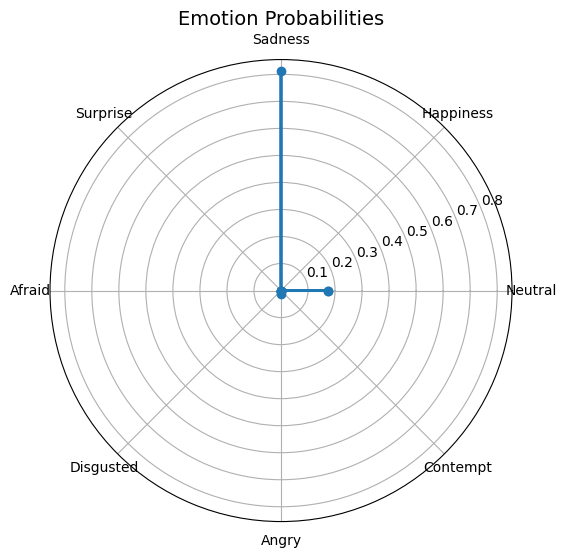

In [18]:
# Load the first image from the test set
sample_image, sample_label = test_dataset[0]


# Create the radar chart for the image's emotion probabilities
radar_chart_for_image(model, sample_image)
plt.show()